In [1]:
import pathlib
import numpy as np
import pandas as pd

Take all the files with words in them and bring them in a single file.

In [2]:
dfs = []
for p in pathlib.Path(".").glob("*.tsv"):
    df = (pd.read_csv(p, sep="\t", names=["n", "word", "eng"])
          .assign(lang=str(p.parts[-1]).replace(".tsv", ""))
          .assign(word=lambda d: np.where(d['word'].isna(), d['eng'], d['word'])))
    dfs.append(df)
    
df = pd.concat(dfs)
del dfs

In [3]:
import fasttext
path = '/Users/vincent/Development/algorithm-whiteboard-resources/language/lid.176.ftz'
ft_model = fasttext.load_model(path)

from langid.langid import LanguageIdentifier, model
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

import cld3

In [4]:
def pred_ft(s):
    p = ft_model.predict([s])
    return p[0][0][0].replace('__label__', ''), p[1][0][0]

def pred_langid(s):
    return identifier.classify(s)

def pred_cld3(s):
    p = cld3.get_language(s)
    return p.language, p.probability

cld3.get_language("hello there")

LanguagePrediction(language='en', probability=0.9419392943382263, is_reliable=True, proportion=1.0)

Note that I'm ignoring things like `is_reliable` here. This makes the comparison slightly less fair.

In [5]:
import tqdm

In [6]:
predictions_langid = [pred_langid(w) for w in tqdm.tqdm(df['word'])]
predictions_ft = [pred_ft(w) for w in tqdm.tqdm(df['word'])]
predictions_cld3 = [pred_cld3(w) for w in tqdm.tqdm(df['word'])]

100%|██████████| 9999/9999 [00:00<00:00, 13316.55it/s]


In [7]:
df = (df
 .assign(pred_langid = [l for l, p in predictions_langid], 
         pred_langid_p = [p for l, p in predictions_langid],
         pred_ft = [l for l, p in predictions_ft], 
         pred_ft_p = [p for l, p in predictions_ft],
         pred_cld3 = [l for l, p in predictions_cld3], 
         pred_cld3_p = [p for l, p in predictions_cld3]))

In [8]:
from sklearn.metrics import plot_confusion_matrix, classification_report

print(classification_report(df['lang'], df['pred_ft'], labels=list(set(df['lang']))))

              precision    recall  f1-score   support

          eo       0.90      0.44      0.59      1000
          nl       0.89      0.50      0.64      1000
          ar       1.00      0.89      0.94       999
          es       0.66      0.54      0.59      1000
          en       0.35      0.93      0.51      1000
          tr       0.95      0.65      0.77      1000
          de       0.77      0.61      0.68      1000
          lt       0.98      0.46      0.63      1000
          pt       0.83      0.41      0.55      1000
          vi       0.99      0.74      0.85      1000

   micro avg       0.72      0.62      0.66      9999
   macro avg       0.83      0.62      0.68      9999
weighted avg       0.83      0.62      0.68      9999



In [9]:
print(classification_report(df['lang'], df['pred_langid'], labels=list(set(df['lang']))))

              precision    recall  f1-score   support

          eo       1.00      0.05      0.10      1000
          nl       0.81      0.28      0.42      1000
          ar       1.00      0.86      0.93       999
          es       0.50      0.29      0.37      1000
          en       0.23      0.93      0.37      1000
          tr       0.96      0.41      0.57      1000
          de       0.59      0.51      0.55      1000
          lt       0.90      0.41      0.56      1000
          pt       0.77      0.14      0.24      1000
          vi       1.00      0.78      0.88      1000

   micro avg       0.54      0.47      0.50      9999
   macro avg       0.78      0.47      0.50      9999
weighted avg       0.78      0.47      0.50      9999



In [10]:
print(classification_report(df['lang'], df['pred_cld3'], labels=list(set(df['lang']))))

              precision    recall  f1-score   support

          eo       0.68      0.17      0.27      1000
          nl       0.69      0.33      0.44      1000
          ar       1.00      0.63      0.77       999
          es       0.60      0.15      0.24      1000
          en       0.54      0.19      0.28      1000
          tr       0.85      0.31      0.46      1000
          de       0.66      0.36      0.47      1000
          lt       0.84      0.38      0.53      1000
          pt       0.65      0.18      0.28      1000
          vi       0.96      0.47      0.63      1000

   micro avg       0.78      0.32      0.45      9999
   macro avg       0.75      0.32      0.44      9999
weighted avg       0.75      0.32      0.44      9999



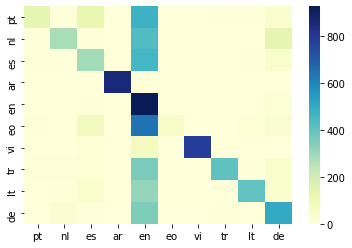

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = list(set(df['lang']))
cm = confusion_matrix(df['lang'], df['pred_langid'], labels=labels)
f = sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap="YlGnBu")

Given just words, it seems to overfit on English. Let's zoom in on a single word though.

In [13]:
df.loc[lambda d: d['word'] == 'die']

,n,word,eng,lang,pred_langid,pred_langid_p,pred_ft,pred_ft_p,pred_cld3,pred_cld3_p
39,40,die,which,nl,de,0.641598,de,0.976931,af,1.0
193,194,die,who,nl,de,0.641598,de,0.976931,af,1.0
288,289,die,those,nl,de,0.641598,de,0.976931,af,1.0
608,609,die,die,en,de,0.641598,de,0.976931,af,1.0
28,29,die,the,de,de,0.641598,de,0.976931,af,1.0
39,40,die,which,de,de,0.641598,de,0.976931,af,1.0
193,194,die,who,de,de,0.641598,de,0.976931,af,1.0


Even in Arabic we make mistakes.

In [14]:
df.loc[lambda d: d['lang'] == 'ar'].groupby('pred_ft').size()

pred_ft
ar     894
arz      5
ca       1
cy       1
en       1
es       3
fa      75
ia       1
lb       1
ml       1
mzn      1
pnb      1
ps       2
ug       3
ur       9
dtype: int64

Arabic is being confused with Persian mainl. But also other language including Urdu.

Very suprisingly, it even confuses it with spanish!

In [15]:
df.loc[lambda d: d['lang'] == 'ar'].loc[lambda d: d['pred_ft'] == 'es']

,n,word,eng,lang,pred_langid,pred_langid_p,pred_ft,pred_ft_p,pred_cld3,pred_cld3_p
420,421,صحيح,correct,ar,ar,0.999297,es,0.730285,ar,0.869402
454,455,صحيح,true,ar,ar,0.999297,es,0.730285,ar,0.869402
560,561,وحيد,lone,ar,ar,0.993102,es,0.674831,ar,0.574395


Let's see if this system fares better if we don't compare a single word, but instead have "fake" sentences of multiple words.

In [16]:
from memo import memfunc, memlist

def generate_fake_sentence(lang="en", sent_len=5):
    return " ".join(df.loc[lambda d: d['lang'] == lang].sample(sent_len)['word'])

data = []

@memlist(data=data)
def create_sent_dataf(sent_len=5, n_samples=50):
    dfs = []
    for lang in labels:
        dfs.append(
            pd.DataFrame({'sent': [generate_fake_sentence(lang, sent_len) for i in range(n_samples)], 
                          'lang': [lang for i in range(n_samples)]}) 
        )

    sent_df = pd.concat(dfs)
    
    predictions_langid = [pred_langid(w) for w in sent_df['sent']]
    predictions_ft = [pred_ft(w) for w in sent_df['sent']]
    predictions_cld3 = [pred_cld3(w) for w in sent_df['sent']]
    
    sent_df = (sent_df
         .assign(pred_langid = [l for l, p in predictions_langid], 
                 pred_langid_p = [p for l, p in predictions_langid],
                 pred_ft = [l for l, p in predictions_ft], 
                 pred_ft_p = [p for l, p in predictions_ft],
                 pred_cld3 = [l for l, p in predictions_cld3]))
    
    d_langid = classification_report(sent_df['lang'], 
                                     sent_df['pred_langid'], 
                                     labels=list(set(df['lang'])), 
                                     output_dict=True)
    d_fasttext = classification_report(sent_df['lang'], 
                                       sent_df['pred_ft'], 
                                       labels=list(set(df['lang'])), 
                                       output_dict=True)
    d_cld3 = classification_report(sent_df['lang'], 
                                    sent_df['pred_cld3'], 
                                    labels=list(set(df['lang'])), 
                                    output_dict=True)
    
    return {'fasttext': d_fasttext['weighted avg'], 
            'langid': d_langid['weighted avg'],
            'cld3': d_cld3['weighted avg']}

In [17]:
import tqdm 

for sent_len in tqdm.tqdm([1,2,3,4,5,6,7]):
    create_sent_dataf(sent_len=sent_len)

100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


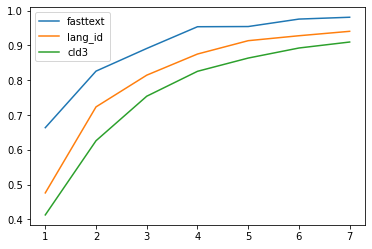

In [18]:
import matplotlib.pylab as plt 

pltr = pd.DataFrame([{'len': d['sent_len'], 
                     'ft_f1': d['fasttext']['f1-score'], 
                     'lang_id_f1': d['langid']['f1-score'],
                     'cld3': d['cld3']['f1-score']} for d in data])

plt.plot(pltr['len'], pltr['ft_f1'], label='fasttext')
plt.plot(pltr['len'], pltr['lang_id_f1'], label='lang_id')
plt.plot(pltr['len'], pltr['cld3'], label='cld3')
plt.legend()

We also see that the performance is good across languages with longer texts.

In [19]:
labels = list(set(df['lang']))

dfs = []
for lang in labels:
    dfs.append(
        pd.DataFrame({'sent': [generate_fake_sentence(lang, 7) for i in range(1000)], 
                      'lang': [lang for i in range(1000)]}) 
    )

sent_df = pd.concat(dfs)

predictions_langid = [pred_langid(w) for w in sent_df['sent']]
predictions_ft = [pred_ft(w) for w in sent_df['sent']]

sent_df = (sent_df
     .assign(pred_langid = [l for l, p in predictions_langid], 
             pred_langid_p = [p for l, p in predictions_langid],
             pred_ft = [l for l, p in predictions_ft], 
             pred_ft_p = [p for l, p in predictions_ft]))

In [20]:
print(classification_report(sent_df['lang'], sent_df['pred_ft'], labels=list(set(df['lang']))))

              precision    recall  f1-score   support

          pt       0.99      0.95      0.97      1000
          nl       1.00      0.95      0.97      1000
          es       0.96      0.98      0.97      1000
          ar       1.00      1.00      1.00      1000
          en       0.97      0.99      0.98      1000
          eo       1.00      0.97      0.98      1000
          vi       1.00      1.00      1.00      1000
          tr       1.00      0.99      1.00      1000
          lt       1.00      0.98      0.99      1000
          de       0.98      0.99      0.98      1000

   micro avg       0.99      0.98      0.98     10000
   macro avg       0.99      0.98      0.98     10000
weighted avg       0.99      0.98      0.98     10000



In [21]:
sent_df.groupby(['lang', 'pred_ft']).size()

lang  pred_ft
ar    ar         998
      fa           2
de    af           1
      de         992
      en           6
                ... 
tr    sh           2
      tl           1
      tr         994
vi    vi         999
      war          1
Length: 64, dtype: int64